# CNN-Experiment

The goal of this experiment is for me to follow tutorials to learn about Convolution Neural Networks (CNNs) using the MNIST dataset with the PyTorch framework.

I'm mainly following this tutorial: https://medium.com/@nutanbhogendrasharma/pytorch-convolutional-neural-network-with-mnist-dataset-4e8a4265e118, and annotating this notebook with my thoughts/learnings.

In [16]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.nn as nn

In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

It seems my machine (MacBook Pro M3) is using the CPU (which is weird, I thought it would've used the GPU and like 40-core memory or whatever advanced specs it has, but ok?). At least it works!

Now I need to import the dataset. It's a large image dataset, and in `experiments.ipynb`, I used Huggingface to download the dataset because I was getting all sorts of weird SSL issues. The tutorial I'm following here is using the following method, which seems to work fine!

In [5]:
# getting training and testing datasets

train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)

test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:05<00:00, 1896721.19it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1248911.71it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3706331.03it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 11160239.47it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Ok so we got the train and test datasets, and converted them to a Tensor object. Let's check the dimensions.

In [10]:
train_data.data.size()

torch.Size([60000, 28, 28])

In [9]:
test_data.data.size()

torch.Size([10000, 28, 28])

Plotting one of the images to see what it looks like...

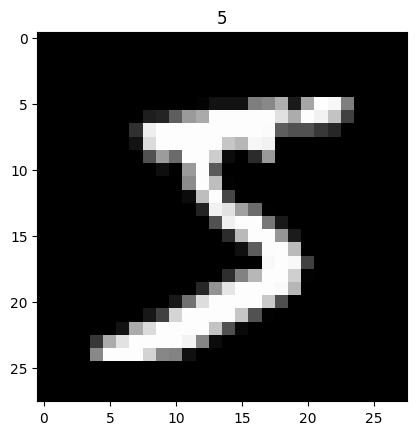

In [12]:
plt.imshow(train_data.data[0], cmap='gray')
plt.title('%i' % train_data.targets[0])
plt.show()

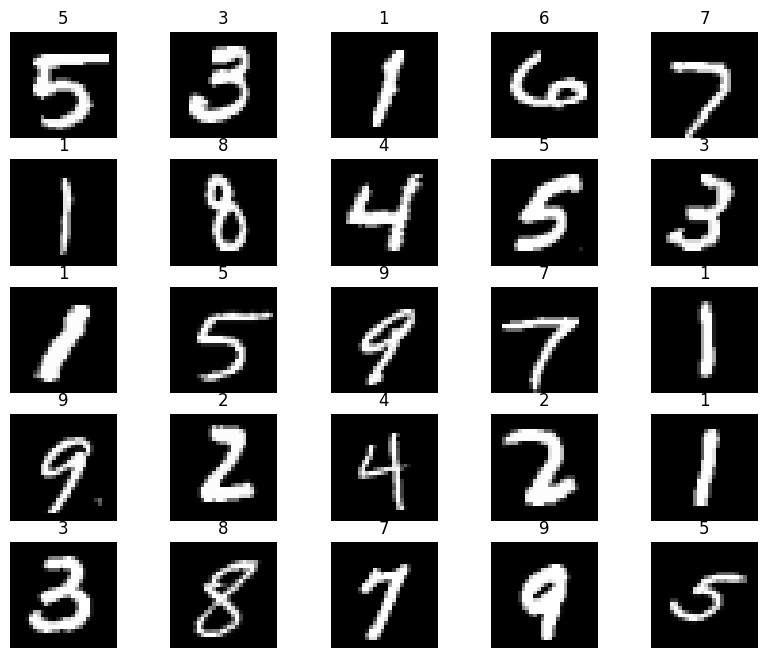

In [13]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Now since the dataset is so large, we can create a DataLoader object using `torch.utils.data`. This also effectively creates mini-batches of the data to train the model and allow re-shuffling betweene epochs.

In [15]:
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x14080ac60>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x125033cb0>}

The next step is to make the CNN model. I copy-pasted the code as-is in the tutorial, but added comments to check my understanding of these concepts.

In [ ]:
class CNN(nn.Module):

    def __init__(self):
        # so it seems we're inheriting a superclass from torch.nn.module, called CNN
        # I tried to hover over the module but did not get anything useful
        # anyway, it's not relevant right now, but I should be able to eventually explain 
        # where/why we are inheriting this superclass
        super(CNN, self).__init__()   

        # now we're defining a method called conv1
        self.conv1 = nn.Sequential( # it seems we're making a Sequential container
            # found some info about Sequential: https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html
            # it seems to be a container to run the model(s) contained within, sequentially (no surprises there)
            nn.Conv2d( # ok so now we're defining a 2D convolution model
                # some documentation: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
                in_channels=1, # defining the number of channels in the input image
                    # follow-up question, what is a channel? is that like RGB?              
                out_channels=16, # defining the number of channels produced by the convolution
                    # question: why does the number of channels change from 1 to 16?
                    # and how do we know that the output number of channels is exactly 16?             
                kernel_size=5, # this is the size of the convolving kernel      
                    # again, why is it 5 specifically?        
                stride=1, # defining the stride of the convolution      
                    # from 'Deep Learning with Python' by Chollet, 
                    # 'stride' is how much the feature map gets downsampled
                    # so in this case, the feature map is getting downsampled by a factor of 1             
                padding=2, # defining how much padding is added to all 4 sides of the input
                    # not entirely sure why we'd want to add padding though?
                    # like what does this do? does it help with the stride or something?                   
            ),                              
            nn.ReLU(), # adding a Rectified Linear Unit layer                     
            nn.MaxPool2d(kernel_size=2), # adding a MaxPool layer    
        )

        # now we're creating our second convolution block method
        self.conv2 = nn.Sequential( # sequential method     
            nn.Conv2d(16, 32, 5, 1, 2), # another Convolution operation with the same parameters as above
                # interesting that this time the keywords are not specified      
            nn.ReLU(), # adding a ReLU layer                     
            nn.MaxPool2d(2), # adding a final max-pooling layer                
        )        

        # [original comment, not mine] fully connected layer, output 10 classes
        # finally defining a method for the output layer
        self.out = nn.Linear(32 * 7 * 7, 10)  # setting the output layer to linear

    def forward(self, x):
        # defining a function for forward selection
        x = self.conv1(x) # now using the previously-defined 1st block of convolution
        x = self.conv2(x) # [original comment, not mine] flatten the output of conv2 to (batch_size, 32 * 7 * 7)
            # applying the second block of convolution, also previously-defined
        x = x.view(x.size(0), -1) # not sure what this is, but eh      
        output = self.out(x)
        return output, x    # [original comment, not mine] return x for visualization